# Titanic

In [1]:
# Import core libraries for data manipulation
import pandas as pd
import numpy as np

# Import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style='whitegrid')

# Ensure plots are displayed inline in the Jupyter Notebook
%matplotlib inline

In [2]:
# Load the dataset from the CSV file
train_df = pd.read_csv('train.csv')

# Confirmation message
print("Train data loaded successfully!")

Train data loaded successfully!


In [4]:
# 1. Check the dimensions of the dataset (Rows, Columns)
print(f"Shape of the dataset: {train_df.shape}")

Shape of the dataset: (891, 12)


In [5]:
# 2. Display the first 5 rows to inspect the data values and column names
display(train_df.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# 3. Get a concise summary of the dataframe
print("\n" + "="*30 + "\nData Information:\n" + "="*30)
train_df.info()


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
# 1. Calculate missing value statistics
missing_count = train_df.isnull().sum()
missing_percent = (train_df.isnull().sum() / len(train_df)) * 100

# Create a DataFrame to display the missing data statistics cleanly
missing_data = pd.DataFrame({'Total Missing': missing_count, 'Percentage (%)': missing_percent})
# Filter to show only columns with missing values and sort by percentage
missing_data = missing_data[missing_data['Total Missing'] > 0].sort_values(by='Percentage (%)', ascending=False)

print("Missing Data Statistics:")
display(missing_data)

Missing Data Statistics:


,Total Missing,Percentage (%)
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


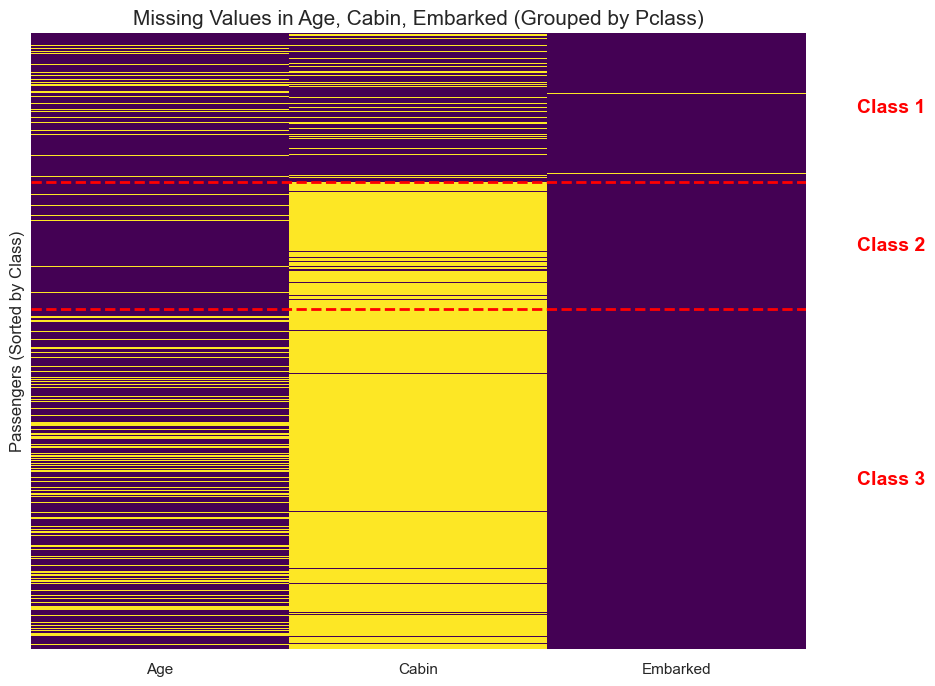

In [10]:
# 1. Sort data by Pclass to see the structure
sorted_df = train_df.sort_values(by=['Pclass', 'Survived'])

# 2. Select only the columns we want to visualize
# We keep the index from sorted_df to maintain the order
cols_to_plot = ['Age', 'Cabin', 'Embarked']
heatmap_data = sorted_df[cols_to_plot]

# 3. Calculate the boundary indices for each Pclass to draw separator lines
# This helps us see where Class 1 ends and Class 2 begins
class_counts = sorted_df['Pclass'].value_counts(sort=False).sort_index()
# Calculate cumulative sum to get the boundary lines: [Count_1, Count_1+Count_2]
boundaries = class_counts.cumsum().values[:-1] 

# 4. Draw the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data.isnull(), cbar=False, cmap='viridis', yticklabels=False)

# Add horizontal lines to separate Pclasses
for boundary in boundaries:
    plt.axhline(boundary, color='red', lw=2, linestyle='--')

# Add text labels for Pclass zones (placed roughly in the middle of each zone)
# We use the y-axis coordinates to place the text
y_positions = [class_counts[1]/2, class_counts[1] + class_counts[2]/2, class_counts[1] + class_counts[2] + class_counts[3]/2]
plt.text(3.2, y_positions[0], 'Class 1', color='red', fontsize=14, weight='bold', verticalalignment='center')
plt.text(3.2, y_positions[1], 'Class 2', color='red', fontsize=14, weight='bold', verticalalignment='center')
plt.text(3.2, y_positions[2], 'Class 3', color='red', fontsize=14, weight='bold', verticalalignment='center')

plt.title('Missing Values in Age, Cabin, Embarked (Grouped by Pclass)', fontsize=15)
plt.ylabel('Passengers (Sorted by Class)', fontsize=12)
plt.show()

### Missing Value Analysis Observations

Based on the Heatmap sorted by **Pclass**, we observed that missing values are not missing at random (MAR), but are structurally related to **Pclass**:

1.  **Embarked**: The only 2 missing values appear in **Class 1**, suggesting we can likely infer them from other Class 1 attributes rather than using a simple mode.
2.  **Cabin**:
    * **Class 1**: Shows significantly fewer missing values (darker regions).
    * **Class 2 & 3**: Almost entirely yellow (missing).
    * *Inference:* The presence of a `Cabin` record is a strong proxy for socio-economic status. We should capture this "missingness" information rather than dropping the column.
3.  **Age**:
    * **Class 2**: Relatively complete data.
    * **Class 3**: Shows the highest density of missing values.
    * *Inference:* Since age availability varies by class, using a global mean to impute `Age` would bias the data (likely overestimating the age of Class 3 passengers). We must use **Pclass** (or Titles) as a grouper for imputation.

In [11]:
# Filter the dataframe to find the specific rows where 'Embarked' is missing
missing_embarked_passengers = train_df[train_df['Embarked'].isnull()]

print("Passengers with missing Embarked information:")
display(missing_embarked_passengers)

Passengers with missing Embarked information:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


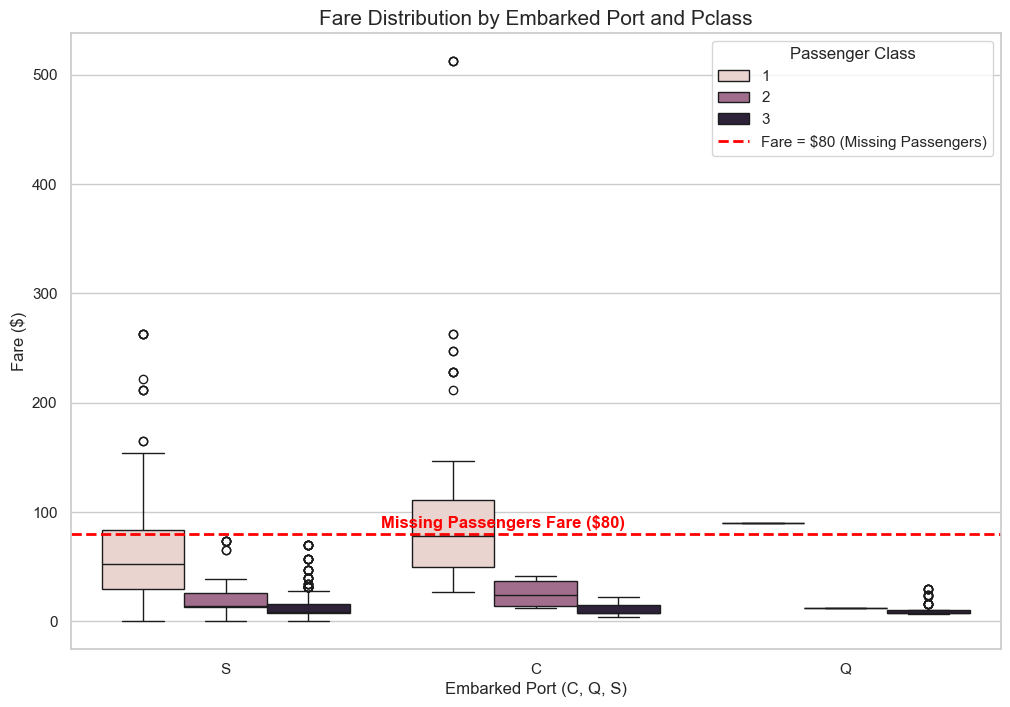

In [13]:
# Create a Boxplot to visualize Fare distribution across Embarked ports and Pclasses
plt.figure(figsize=(12, 8))

# x: Embarked port, y: Fare, hue: Pclass (to show all classes side-by-side)
sns.boxplot(x='Embarked', y='Fare', hue='Pclass', data=train_df)

# Add a horizontal red line at Fare = 80 (the fare of Mrs. Stone & Miss Icard)
plt.axhline(y=80, color='red', linestyle='--', linewidth=2, label='Fare = $80 (Missing Passengers)')

# Add text annotation to make it clear
plt.text(x=0.5, y=85, s='Missing Passengers Fare ($80)', color='red', fontsize=12, weight='bold')

plt.title('Fare Distribution by Embarked Port and Pclass', fontsize=15)
plt.ylabel('Fare ($)', fontsize=12)
plt.xlabel('Embarked Port (C, Q, S)', fontsize=12)
plt.legend(title='Passenger Class')

plt.show()

### Missing Value Inference: Embarked

**Problem:** Two passengers (IDs 62 & 830) have missing `Embarked` values.

**Inference Process:**
1.  **Identification:** Both passengers are **female**, travel in **Pclass 1**, and paid a fare of **$80.00**.

2.  **Evidence Analysis (Fare Distribution):**
    * We compared the Fare distribution for Pclass 1 across all three ports (C, Q, S).
    * **S:** The median fare for Pclass 1 is significantly lower than $80.
    * **C:** The median fare for Pclass 1 is higher, and the $80 price point falls centrally within the Interquartile Range (IQR) of this port.

3.  **Conclusion:** Based on the fare structure, it is highly probable that these passengers boarded at **C**.

4.  **Action:** Imputed the missing values with **C**.

In [14]:
# 1. Fill the missing Embarked values with 'C' based on our analysis
train_df['Embarked'] = train_df['Embarked'].fillna('C')

# 2. Verify that there are no more missing values in Embarked
missing_embarked_count = train_df['Embarked'].isnull().sum()
print(f"Number of missing values in Embarked after imputation: {missing_embarked_count}")

# 3. Cross-check the specific rows to ensure they are filled
print("\nVerification for specific passengers:")
display(train_df.loc[[61, 829], ['Name', 'Pclass', 'Fare', 'Embarked']])

Number of missing values in Embarked after imputation: 0

Verification for specific passengers:


,Name,Pclass,Fare,Embarked
61,"Icard, Miss. Amelie",1,80.0,C
829,"Stone, Mrs. George Nelson (Martha Evelyn)",1,80.0,C


In [15]:
# 1. Create a new feature 'Deck'
# Logic: If Cabin is not null, take the first character. If it is null, use 'M'.
# We use .fillna('M') first to handle NaNs, then .str[0] to extract the letter.
train_df['Deck'] = train_df['Cabin'].fillna('M').str[0]

# 2. Check the distribution of the new 'Deck' feature
deck_counts = train_df['Deck'].value_counts().sort_index()

print("Distribution of Deck feature:")
print(deck_counts)

# 3. Preview the first few rows to verify the extraction
display(train_df[['Cabin', 'Deck']].head())

Distribution of Deck feature:
Deck
A     15
B     47
C     59
D     33
E     32
F     13
G      4
M    687
T      1
Name: count, dtype: int64


,Cabin,Deck
0,NaN,M
1,C85,C
2,NaN,M
3,C123,C
4,NaN,M


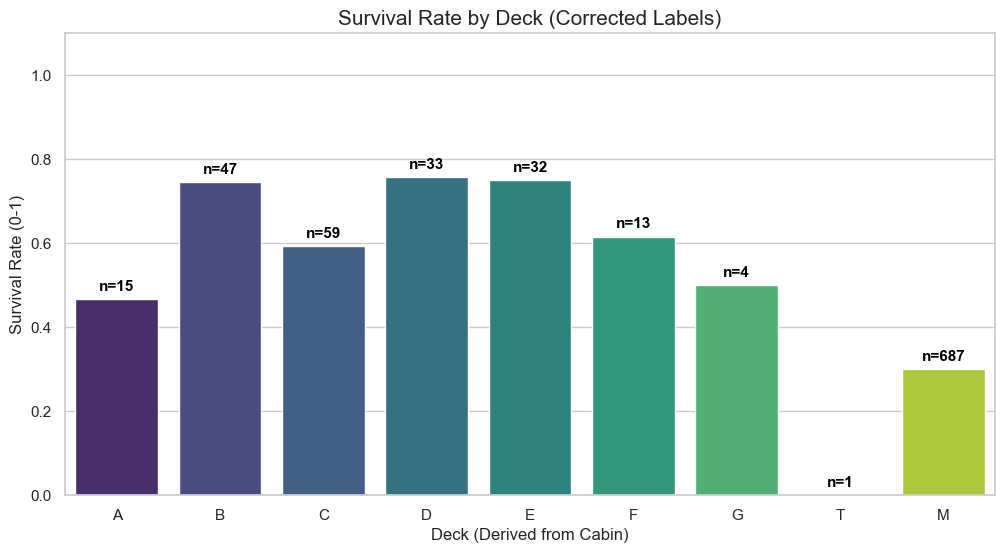

Verification Table:


,Deck,Survival Rate,Count
0,A,0.466667,15
1,B,0.744681,47
2,C,0.593220,59
3,D,0.757576,33
4,E,0.750000,32
5,F,0.615385,13
6,G,0.500000,4
7,M,0.299854,687
8,T,0.000000,1


In [20]:
# 1. Prepare statistics
deck_stats = train_df.groupby('Deck')['Survived'].agg(['mean', 'count']).reset_index()
deck_stats.rename(columns={'mean': 'Survival Rate', 'count': 'Count'}, inplace=True)

# 2. Visualization
plt.figure(figsize=(12, 6))

# Define the logical order
deck_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'M']

# Draw the barplot
ax = sns.barplot(
    x='Deck', 
    y='Survived', 
    data=train_df, 
    order=deck_order, 
    palette='viridis', 
    errorbar=None, 
    hue='Deck', 
    hue_order=deck_order, 
    legend=False
)

# 3. Add sample size labels (n=...)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    if pd.isna(height): height = 0
    
    # Get the correct count
    current_deck = deck_order[i]
    count = deck_stats.loc[deck_stats['Deck'] == current_deck, 'Count'].values[0]
    
    # Place text
    ax.text(p.get_x() + p.get_width()/2., height + 0.02, 
            f'n={count}', ha="center", color='black', fontsize=11, weight='bold')

plt.title('Survival Rate by Deck (Corrected Labels)', fontsize=15)
plt.ylabel('Survival Rate (0-1)', fontsize=12)
plt.xlabel('Deck (Derived from Cabin)', fontsize=12)
plt.ylim(0, 1.1)
plt.show()

# Display the table to double-check
print("Verification Table:")
display(deck_stats)

Deck Distribution by Pclass:


Pclass,1,2,3
Deck,,,
A,15,0,0
B,47,0,0
C,59,0,0
D,29,4,0
E,25,4,3
F,0,8,5
G,0,0,4
M,40,168,479
T,1,0,0


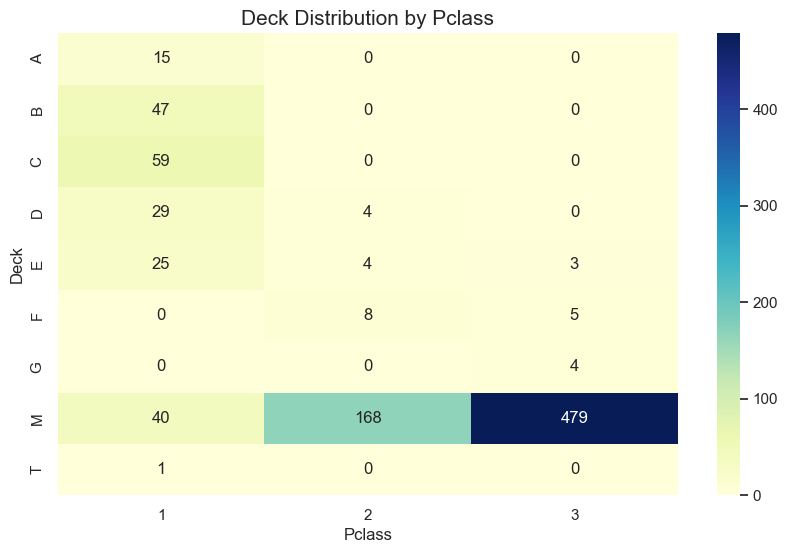

In [21]:
# 1. Create a cross-tabulation of Deck vs Pclass
deck_pclass_crosstab = pd.crosstab(train_df['Deck'], train_df['Pclass'])

# 2. Display the raw counts
print("Deck Distribution by Pclass:")
display(deck_pclass_crosstab)

# 3. Visualizing the relationship with a Heatmap
plt.figure(figsize=(10, 6))
# annot=True shows the numbers in the cells
# fmt='d' ensures the numbers are displayed as integers
sns.heatmap(deck_pclass_crosstab, annot=True, fmt='d', cmap='YlGnBu')

plt.title('Deck Distribution by Pclass', fontsize=15)
plt.ylabel('Deck', fontsize=12)
plt.xlabel('Pclass', fontsize=12)
plt.show()

In [22]:
# 1. Replace rare decks with their nearest neighbors based on Pclass and logic
# 'T' (1 passenger, Pclass 1) -> Merged into 'C' (Most common Pclass 1 deck)
# 'G' (4 passengers, Pclass 3) -> Merged into 'F' (Adjacent lower deck, mixed Pclass 2/3)
train_df['Deck'] = train_df['Deck'].replace({'T': 'C', 'G': 'F'})

# 2. Verify the new distribution
new_deck_counts = train_df['Deck'].value_counts().sort_index()

print("New Deck Distribution after Grouping:")
print(new_deck_counts)

# 3. Quick sanity check of survival rates after grouping
print("\nNew Survival Rates:")
display(train_df.groupby('Deck')['Survived'].mean())

New Deck Distribution after Grouping:
Deck
A     15
B     47
C     60
D     33
E     32
F     17
M    687
Name: count, dtype: int64

New Survival Rates:


Deck
A    0.466667
B    0.744681
C    0.583333
D    0.757576
E    0.750000
F    0.588235
M    0.299854
Name: Survived, dtype: float64

### Feature Engineering: Cabin to Deck

**Problem:** The `Cabin` column has **77% missing values**. However, the presence of a cabin record (or lack thereof) and the deck level are strong indicators of survival.

**Strategy & Execution:**
1.  **Extraction:** We extracted the first letter of the `Cabin` to create a new feature **`Deck`**.
2.  **Missing Value Handling:** Missing values were recoded as **`'M'`**, treating "missingness" as a distinct category.
    * *Observation:* The `M` group has a significantly lower survival rate (~30%) compared to passengers with known decks, confirming that having a cabin record is a proxy for survival advantage.
3.  **Rare Label Grouping:**
    * **Deck T (n=1):** Identified as a Pclass 1 passenger. Merged into **Deck C** (the most common Pclass 1 deck) to eliminate an outlier group.
    * **Deck G (n=4):** Identified as Pclass 3 passengers. Merged into **Deck F** (the most common Pclass 3 that has records) to consolidate sparse lower-deck data.

**Final Outcome:**
We transformed a messy text column into a clean categorical feature with 7 robust groups (**A, B, C, D, E, F, M**).
* **High Survival Decks:** B, D, E (Survival Rate ~75%)
* **Moderate Survival Decks:** A, C, F (Survival Rate ~46-59%)
* **Low Survival Group:** M (Survival Rate ~30%)

### Missing Value Analysis: Age Strategy

**Hypothesis:** `Age` is not missing completely at random. We suspect that **Passenger Class (`Pclass`)** influences age distribution (e.g., Class 1 passengers might be older on average).

**Validation Method:**
* **Visual:** Boxplot of `Age` grouped by `Pclass`.
* **Statistical:** Compare the **Median Age** of each class.

**Decision Logic:**
1.  **If Medians are distinct:** We must use **Grouped Imputation** (impute Class 1 missing ages with Class 1 median, etc.).
2.  **If Medians are similar:** We can use a **Global Mean/Median**.

/var/folders/bb/5yjzvr_10jq7kd546ghdx78w0000gn/T/ipykernel_93726/1743295256.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Pclass', y='Age', data=train_df, palette='winter')


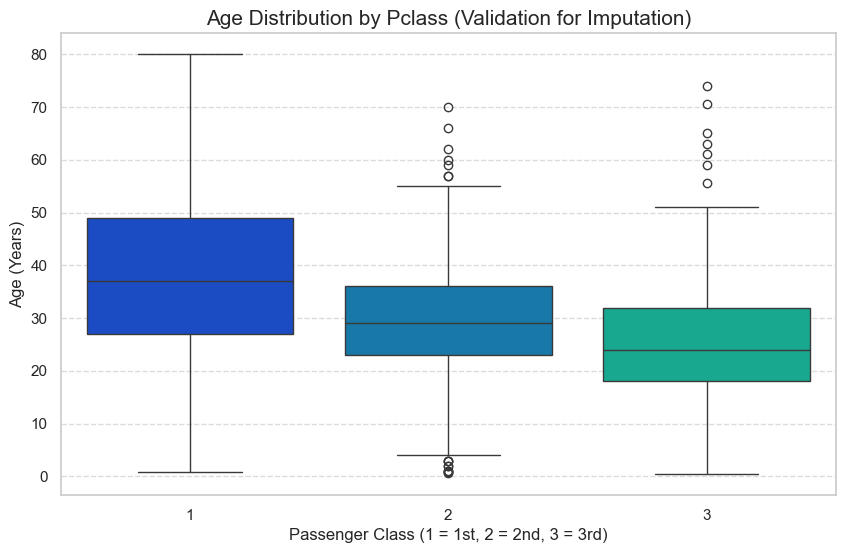

Median Age by Pclass:
Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64


In [23]:
# 1. Visualize the distribution of Age across different Pclasses
plt.figure(figsize=(10, 6))
# Using a clear palette to distinguish classes
sns.boxplot(x='Pclass', y='Age', data=train_df, palette='winter')

plt.title('Age Distribution by Pclass (Validation for Imputation)', fontsize=15)
plt.ylabel('Age (Years)', fontsize=12)
plt.xlabel('Passenger Class (1 = 1st, 2 = 2nd, 3 = 3rd)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# 2. Calculate the precise Median Age for each class
# This confirms if the visual difference is statistically significant enough to act on
age_medians = train_df.groupby('Pclass')['Age'].median()
print("Median Age by Pclass:")
print(age_medians)

### Imputation Strategy Decision: Age

**Observation:**
The Boxplot analysis reveals a significant correlation between `Pclass` and `Age`:
* **Class 1 Median:** 37.0 Years
* **Class 2 Median:** 29.0 Years
* **Class 3 Median:** 24.0 Years

**Conclusion:**
There is a **13-year gap** between Class 1 and Class 3.
* **Rejected Strategy:** Global Mean/Median Imputation. This would introduce significant bias (underestimating Class 1 age and overestimating Class 3 age).
* **Selected Strategy:** Grouped Imputation. We will impute missing values using the median age of the specific **`Pclass`** the passenger belongs to.

In [25]:
# 1. Impute missing Age values based on Pclass median
# transform('median') calculates the median for each group (Pclass) 
# and aligns it with the original index, making filling easy.
train_df['Age'] = train_df['Age'].fillna(train_df.groupby('Pclass')['Age'].transform('median'))

# 2. Verify Imputation
# Check if there are any missing values left in Age
missing_age_count = train_df['Age'].isnull().sum()
print(f"Number of missing values in Age after imputation: {missing_age_count}")

# 3. Final Check of Data Integrity
# Ensure we haven't introduced any negative values or weird outliers
print("\nAge Description after Imputation:")
print(train_df['Age'].describe())

Number of missing values in Age after imputation: 0

Age Description after Imputation:
count    891.000000
mean      29.066409
std       13.244532
min        0.420000
25%       22.000000
50%       26.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64


In [26]:
# 1. Preview the first 5 rows to see the current state
print("Current Dataframe Head:")
display(train_df.head())

# 2. Check data types and remaining missing values
print("\nDataframe Info:")
print(train_df.info())

# 3. Check statistical summary for numerical columns
# This helps us spot potential outliers in Fare or Age
print("\nStatistical Summary:")
display(train_df.describe())

Current Dataframe Head:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,M
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,M
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,M



Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Deck         891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB
None

Statistical Summary:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.066409,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.244532,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,37.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Data Cleaning: Dropping Irrelevant Features

**Objective:** Remove features that do not contribute to the model's predictive power or have been replaced by engineered features.

**Actions:**
1.  **Drop `PassengerId`:** This is merely an index and contains no information about the passenger's survival probability.
2.  **Drop `Cabin`:** This column has been successfully transformed into the **`Deck`** feature. The original column is now redundant and contains too many missing values to be useful.

In [27]:
# 1. Drop the irrelevant columns
train_df = train_df.drop(['PassengerId', 'Cabin'], axis=1)

# 2. Verify the drop
# We check the shape and the first few rows to ensure they are gone
print(f"New Dataframe Shape: {train_df.shape}")
print("\nFirst 5 rows after dropping:")
display(train_df.head())

New Dataframe Shape: (891, 11)

First 5 rows after dropping:


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,M
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,M
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,M


### Feature Engineering: Name to Title

**Hypothesis:**
The `Name` column is rich in metadata. The **Title** (e.g., Mr., Mrs., Master., Dr.) acts as a proxy for:
1.  **Gender:** (Mr. vs Mrs.)
2.  **Age:** (Master. denotes a young boy, usually under 12)
3.  **Socio-Economic Status:** (Dr., Rev., Sir., Countess. denote high status)

**Strategy:**
1.  **Extraction:** Parse the `Name` string to extract the title.
2.  **Analysis:** Evaluate the survival rate of each raw title to inform grouping logic.
3.  **Simplification:**
    * **Standardize:** Map French titles (Mlle, Mme) to English equivalents.
    * **Group Rare Titles:** Combine distinct but rare titles (e.g., Capt, Col, Major) into a single **"Rare"** category to prevent overfitting on singleton categories.

In [28]:
# 1. Extract Title from Name using Regular Expression
# The regex looks for a space, followed by letters, followed by a dot.
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 2. Check the distribution of raw titles
print("Raw Title Distribution:")
print(train_df['Title'].value_counts())

# 3. Cross-tabulate with Sex to verify consistency
print("\nTitle Distribution by Sex:")
display(pd.crosstab(train_df['Title'], train_df['Sex']))

Raw Title Distribution:
Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

Title Distribution by Sex:


Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


/var/folders/bb/5yjzvr_10jq7kd546ghdx78w0000gn/T/ipykernel_93726/2089610194.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Title', y='Survived', data=train_df, order=order, palette='viridis', errorbar=None)


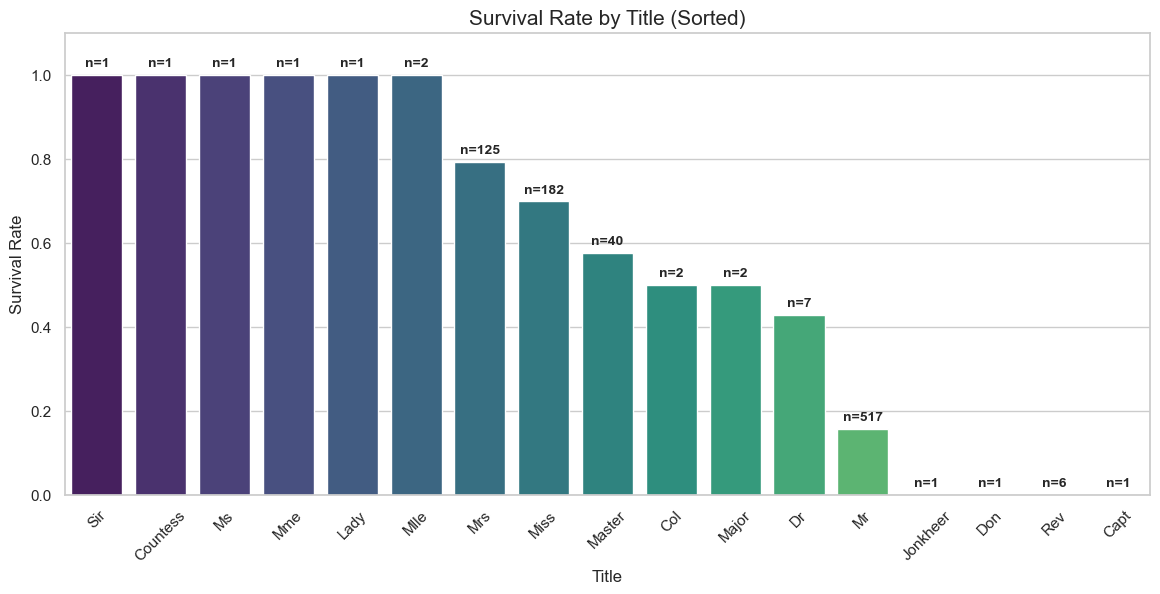

Survival Rates by Title:
Title
Sir         1.000000
Countess    1.000000
Ms          1.000000
Mme         1.000000
Lady        1.000000
Mlle        1.000000
Mrs         0.792000
Miss        0.697802
Master      0.575000
Col         0.500000
Major       0.500000
Dr          0.428571
Mr          0.156673
Jonkheer    0.000000
Don         0.000000
Rev         0.000000
Capt        0.000000
Name: Survived, dtype: float64


In [29]:
# 1. Visualize Survival Rate by Title
plt.figure(figsize=(14, 6))

# Sort by survival rate for better readability
# We calculate the mean survival rate for each title and sort the index
order = train_df.groupby('Title')['Survived'].mean().sort_values(ascending=False).index

sns.barplot(x='Title', y='Survived', data=train_df, order=order, palette='viridis', errorbar=None)

# 2. Add sample counts on top of bars
# Getting the value counts reindexed to match the plot order
title_counts = train_df['Title'].value_counts()

for i, title in enumerate(order):
    count = title_counts[title]
    # Get the survival rate (height of the bar)
    survival_rate = train_df[train_df['Title'] == title]['Survived'].mean()
    
    # Place text
    plt.text(i, survival_rate + 0.02, f'n={count}', ha='center', fontsize=10, weight='bold')

plt.title('Survival Rate by Title (Sorted)', fontsize=15)
plt.ylabel('Survival Rate', fontsize=12)
plt.xlabel('Title', fontsize=12)
plt.xticks(rotation=45) # Rotate labels to avoid overlap
plt.ylim(0, 1.1)
plt.show()

# 3. Print exact survival rates for verification
print("Survival Rates by Title:")
print(train_df.groupby('Title')['Survived'].mean().sort_values(ascending=False))

### Data Exploration: Decoding Titles & Survival

**Observation:**
The analysis of survival rates by title reveals a clear hierarchy of rescue priority based on gender, age, and social status.

**1. The "Women and Children First" Protocol:**
* **`Master` (Boys) vs. `Mr` (Adult Men):**
    * **Master (57.5% Survival):** Represents young boys. Their survival rate is significantly higher than adult men.
    * **Mr (15.7% Survival):** Represents the vast majority of adult males. This group has the **lowest survival probability**, reflecting their lower priority in lifeboat allocation.
* **Female Titles:** `Mrs`, `Miss`, `Mlle`, `Mme`, `Ms`, `Lady`, `Countess` all show consistently high survival rates (mostly >70%, with many at 100%).

**2. The Privilege of Nobility (High Status):**
* **`Sir`, `Countess`, `Lady`:** These titles indicate British nobility. All individuals with these titles in our dataset **survived (100%)**. This suggests that high social status likely correlated with better access to lifeboats or cabins on higher decks.

**3. The "Duty" Group:**
* **`Rev` (Reverend/Clergy):** 0% Survival (0/6).
* **`Capt` (Captain):** 0% Survival.

**4. Glossary of Special Titles:**
* **`Mlle` (Mademoiselle):** French for "Miss". (Survival: 100%)
* **`Mme` (Madame):** French for "Mrs". (Survival: 100%)
* **`Jonkheer`:** Dutch nobility honorific. (Survival: 0%)
* **`Don`:** Spanish/Portuguese honorific for men. (Survival: 0%)
* **`Col`, `Major`, `Capt`:** Military titles.

### Feature Engineering: Title Mapping

**Action:**
We simplified the diverse range of titles into 5 core groups:
1.  **Mr:** Adult males.
2.  **Miss:** Unmarried females (includes `Mlle`, `Ms`).
3.  **Mrs:** Married females (includes `Mme`, `Lady`, `Countess`).
4.  **Master:** Young boys.
5.  **Rare:** All other infrequent titles (`Dr`, `Rev`, `Major`, `Col`, `Capt`, `Don`, `Jonkheer`, `Sir`).

**Goal:**
Reduce cardinality and create robust categories with sufficient sample sizes for the model.

In [30]:
# 1. Define the mapping dictionary
# We use a dictionary to specify the replacement rules clearly
title_mapping = {
    'Mlle': 'Miss', 
    'Ms': 'Miss', 
    'Mme': 'Mrs',
    'Lady': 'Mrs', 
    'Countess': 'Mrs',
    'Don': 'Rare', 
    'Rev': 'Rare', 
    'Dr': 'Rare', 
    'Major': 'Rare', 
    'Sir': 'Rare', 
    'Col': 'Rare', 
    'Capt': 'Rare', 
    'Jonkheer': 'Rare'
}

# 2. Apply the mapping using .replace()
train_df['Title'] = train_df['Title'].replace(title_mapping)

# 3. Verify the new distribution and survival rates
# We expect to see only 5 categories now: Mr, Miss, Mrs, Master, Rare
print("New Title Distribution:")
print(train_df['Title'].value_counts())

print("\nSurvival Rate by Simplified Title:")
print(train_df.groupby('Title')['Survived'].mean().sort_values(ascending=False))

# 4. Drop the original 'Name' column as 'Title' captures the most important info
train_df = train_df.drop(['Name'], axis=1)

# 5. Check the dataframe shape again
print(f"\nDataframe Shape after dropping Name: {train_df.shape}")

New Title Distribution:
Title
Mr        517
Miss      185
Mrs       128
Master     40
Rare       21
Name: count, dtype: int64

Survival Rate by Simplified Title:
Title
Mrs       0.796875
Miss      0.702703
Master    0.575000
Rare      0.285714
Mr        0.156673
Name: Survived, dtype: float64

Dataframe Shape after dropping Name: (891, 11)


### Feature Engineering: Family Size

**Rationale:**
The dataset contains two separate features for family relations: `SibSp` (Siblings/Spouses) and `Parch` (Parents/Children).
By combining them, we can derive the total **`FamilySize`**, which allows us to investigate if the size of a group affects survival chances (e.g., are solo travelers more mobile? or do larger families help each other?).

**Formula:**
`FamilySize` = `SibSp` + `Parch` + 1 (Self)

In [32]:
# --- Cell 18: Calculate FamilySize ---
# Simply adding the columns together plus the passenger themselves
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

# Check the distribution of FamilySize
print("Family Size Distribution:")
print(train_df['FamilySize'].value_counts().sort_index())

Family Size Distribution:
FamilySize
1     537
2     161
3     102
4      29
5      15
6      22
7      12
8       6
11      7
Name: count, dtype: int64


/var/folders/bb/5yjzvr_10jq7kd546ghdx78w0000gn/T/ipykernel_93726/1361221089.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='FamilySize', y='Survived', data=train_df, palette='magma', errorbar=None)


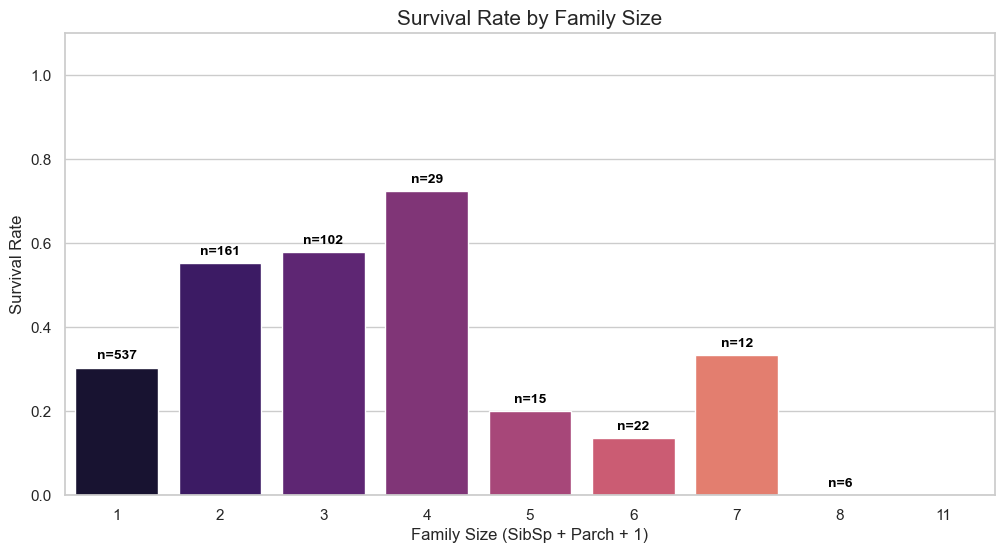


Survival Rate by Family Size:
FamilySize
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64


In [33]:
# --- Cell 19: Visualize FamilySize vs Survival ---
plt.figure(figsize=(12, 6))

# 1. Barplot to show the trend and confidence intervals
# This helps us see the "shape" of survival probability
ax = sns.barplot(x='FamilySize', y='Survived', data=train_df, palette='magma', errorbar=None)

# 2. Add sample counts on top of bars
# Essential to know if "FamilySize=11" is statistically significant
family_counts = train_df['FamilySize'].value_counts().sort_index()

for i, p in enumerate(ax.patches):
    height = p.get_height()
    # Handle cases where height is NaN (if any size has no survivors)
    if pd.isna(height): height = 0
    
    # Get the count for the current family size
    # The x-axis is 0-indexed, but FamilySize starts at 1, so we map carefully
    current_size = i + 1 
    if current_size in family_counts:
        count = family_counts[current_size]
        ax.text(p.get_x() + p.get_width()/2., height + 0.02, 
                f'n={count}', ha="center", color='black', fontsize=10, weight='bold')

plt.title('Survival Rate by Family Size', fontsize=15)
plt.ylabel('Survival Rate', fontsize=12)
plt.xlabel('Family Size (SibSp + Parch + 1)', fontsize=12)
plt.ylim(0, 1.1)
plt.show()

# 3. Print the exact numbers to help us decide on binning
print("\nSurvival Rate by Family Size:")
print(train_df.groupby('FamilySize')['Survived'].mean())

### Feature Engineering: Family Type Binning

**Observation:**
The relationship between `FamilySize` and survival is non-linear (Inverted U-shape):
* **Solo (Size 1):** Low survival (~30%).
* **Small Families (Size 2-4):** Highest survival (~55-72%).
* **Large Families (Size 5+):** Very low survival (<20%).

**Action:**
We bin the continuous `FamilySize` variable into 3 categorical groups:
1.  **Solo:** Family Size = 1
2.  **Small:** Family Size = 2, 3, 4
3.  **Large:** Family Size >= 5

In [34]:
# --- Cell 20: Create Family_Type ---

def get_family_type(size):
    if size == 1:
        return 'Solo'
    elif 2 <= size <= 4:
        return 'Small'
    else:
        return 'Large'

# Apply the function to create the new feature
train_df['Family_Type'] = train_df['FamilySize'].apply(get_family_type)

# Verify the new distribution and survival rates
print("Family Type Distribution:")
print(train_df['Family_Type'].value_counts())

print("\nSurvival Rate by Family Type:")
print(train_df.groupby('Family_Type')['Survived'].mean().sort_values(ascending=False))

Family Type Distribution:
Family_Type
Solo     537
Small    292
Large     62
Name: count, dtype: int64

Survival Rate by Family Type:
Family_Type
Small    0.578767
Solo     0.303538
Large    0.161290
Name: Survived, dtype: float64


In [35]:
# Preview the first 5 rows to see the current state
print("Current Dataframe Head:")
display(train_df.head())

Current Dataframe Head:


,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Title,FamilySize,Family_Type
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S,M,Mr,2,Small
1,1,1,female,38.0,1,0,PC 17599,71.2833,C,C,Mrs,2,Small
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,M,Miss,1,Solo
3,1,1,female,35.0,1,0,113803,53.1000,S,C,Mrs,2,Small
4,0,3,male,35.0,0,0,373450,8.0500,S,M,Mr,1,Solo


### Data Cleaning: Removing Redundant & High-Cardinality Features

**Action:**
We dropped the following features to prevent multicollinearity and reduce noise:
1.  **`SibSp`, `Parch`, `FamilySize`:** These continuous variables are highly correlated with our new categorical feature **`Family_Type`**. Keeping them would introduce multicollinearity, confusing the model.
2.  **`Ticket`:** Not sure what we can do for it right now. Skipped it for now.

In [36]:
# 1. Define columns to drop
# We remove the original family features and the raw Ticket feature
cols_to_drop = ['SibSp', 'Parch', 'FamilySize', 'Ticket']

# 2. Execute the drop
train_df = train_df.drop(cols_to_drop, axis=1)

# 3. Verify the cleanup
print(f"Dropped columns: {cols_to_drop}")
print(f"New Dataframe Shape: {train_df.shape}")

# 4. Final inspection of the clean dataframe
print("\nClean Dataframe Head:")
display(train_df.head())

Dropped columns: ['SibSp', 'Parch', 'FamilySize', 'Ticket']
New Dataframe Shape: (891, 9)

Clean Dataframe Head:


,Survived,Pclass,Sex,Age,Fare,Embarked,Deck,Title,Family_Type
0,0,3,male,22.0,7.2500,S,M,Mr,Small
1,1,1,female,38.0,71.2833,C,C,Mrs,Small
2,1,3,female,26.0,7.9250,S,M,Miss,Solo
3,1,1,female,35.0,53.1000,S,C,Mrs,Small
4,0,3,male,35.0,8.0500,S,M,Mr,Solo


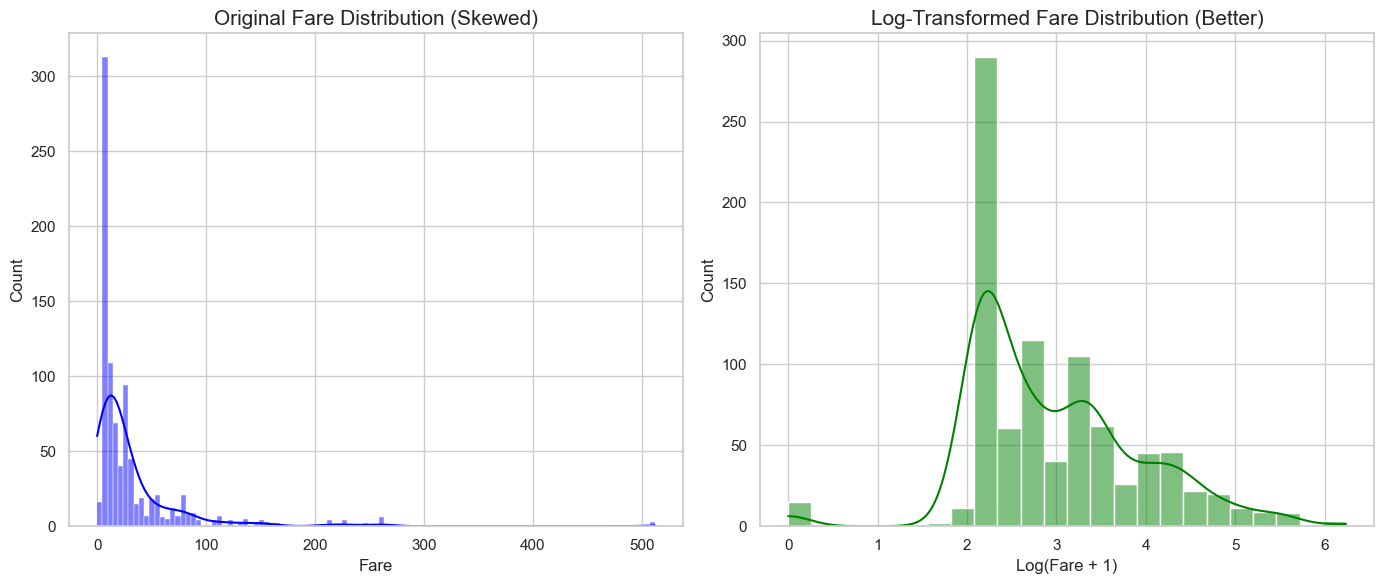

Skewness before log: 4.79
Skewness after log: 0.39


In [37]:
# 1. Visualize the Original Fare Distribution
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_df['Fare'], kde=True, color='blue')
plt.title('Original Fare Distribution (Skewed)', fontsize=15)
plt.xlabel('Fare')

# 2. Visualize the Log-Transformed Fare Distribution
# np.log1p handles log(0) which is undefined, so we use log(x+1)
log_fare = np.log1p(train_df['Fare'])

plt.subplot(1, 2, 2)
sns.histplot(log_fare, kde=True, color='green')
plt.title('Log-Transformed Fare Distribution (Better)', fontsize=15)
plt.xlabel('Log(Fare + 1)')

plt.tight_layout()
plt.show()

# 3. Apply the transformation permanently to the DataFrame
train_df['Fare'] = log_fare

# 4. Check the skewness value (Ideally closer to 0)
print(f"Skewness before log: {np.expm1(train_df['Fare']).skew():.2f}") # Reverting to check original
print(f"Skewness after log: {train_df['Fare'].skew():.2f}")

### Data Transformation: Fare Log-Normal

**Problem:**
The `Fare` feature is highly right-skewed (most passengers paid little, a few paid a lot). This can negatively impact model performance (especially linear models or neural networks).

**Solution:**
We apply a **Log Transformation (`np.log1p`)** to normalize the distribution.
* **Effect:** Reduces the impact of extreme outliers and makes the distribution more Gaussian-like.

/var/folders/bb/5yjzvr_10jq7kd546ghdx78w0000gn/T/ipykernel_93726/230482429.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df.loc[train_df['Survived'] == 1, 'Age'], shade=True, color='green', label='Survived', alpha=0.5)
/var/folders/bb/5yjzvr_10jq7kd546ghdx78w0000gn/T/ipykernel_93726/230482429.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df.loc[train_df['Survived'] == 0, 'Age'], shade=True, color='red', label='Died', alpha=0.5)


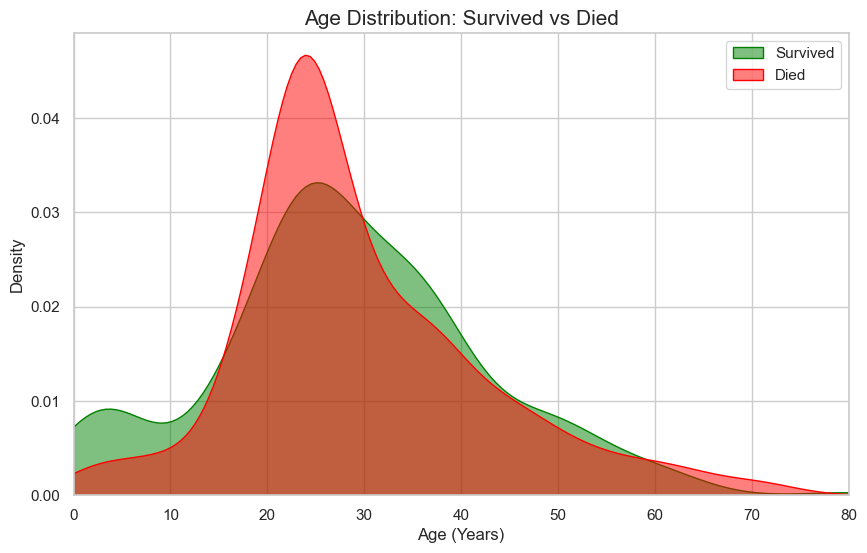

In [39]:
# Cell 24: Visualize Age Distribution by Survival Status
plt.figure(figsize=(10, 6))

# KDE Plot allows us to see the probability density of Age for both groups
sns.kdeplot(train_df.loc[train_df['Survived'] == 1, 'Age'], shade=True, color='green', label='Survived', alpha=0.5)
sns.kdeplot(train_df.loc[train_df['Survived'] == 0, 'Age'], shade=True, color='red', label='Died', alpha=0.5)

plt.title('Age Distribution: Survived vs Died', fontsize=15)
plt.xlabel('Age (Years)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.xlim(0, 80) # Limit x-axis to realistic age range
plt.show()

### Feature Engineering: Age Binning

**Observation from KDE Plot:**
The Age distribution reveals distinct survival patterns:
1.  **Children (< 15):** High survival probability (Green > Red). This aligns with the "Women and Children First" policy.
2.  **Young Adults (15 - 30):** Lower survival probability (Red > Green). This group likely includes many crew members and 3rd class passengers who were less prioritized.
3.  **Adults (31+):** Average survival rates.

**Action:**
We created a new feature **`Age_Group`** with 3 bins:
* `Child`: 0 - 14 years
* `Young`: 15 - 30 years
* `Adult`: 31+ years

Age Group Distribution:
Age_Group
Young    478
Adult    335
Child     78
Name: count, dtype: int64

Survival Rate by Age Group:
Age_Group
Child    0.576923
Adult    0.411940
Young    0.332636
Name: Survived, dtype: float64


/var/folders/bb/5yjzvr_10jq7kd546ghdx78w0000gn/T/ipykernel_93726/394977696.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Age_Group', y='Survived', data=train_df, order=['Child', 'Young', 'Adult'], palette='coolwarm', errorbar=None)


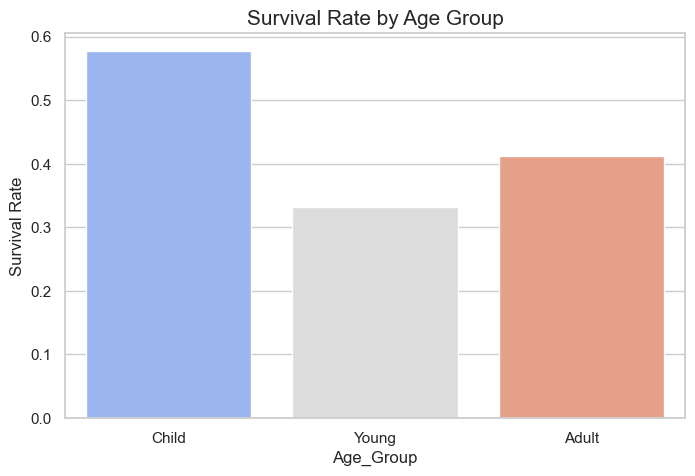

Dropped 'Age' column. Current Shape: (891, 9)


In [41]:
# 1. Define the binning function based on our visual analysis
def get_age_group(age):
    if age < 15:
        return 'Child'
    elif 15 <= age <= 30:
        return 'Young'
    else:
        return 'Adult'

# 2. Apply the binning
train_df['Age_Group'] = train_df['Age'].apply(get_age_group)

# 3. Verify the new feature
print("Age Group Distribution:")
print(train_df['Age_Group'].value_counts())

print("\nSurvival Rate by Age Group:")
# We verify if 'Young' indeed has the lowest survival rate
print(train_df.groupby('Age_Group')['Survived'].mean().sort_values(ascending=False))

# 4. Visualization to confirm the trend
plt.figure(figsize=(8, 5))
# Use a custom order to make it logical
sns.barplot(x='Age_Group', y='Survived', data=train_df, order=['Child', 'Young', 'Adult'], palette='coolwarm', errorbar=None)
plt.title('Survival Rate by Age Group', fontsize=15)
plt.ylabel('Survival Rate', fontsize=12)
plt.show()

# 5. Drop the original Age column (Optional but recommended to reduce noise)
# Since Age_Group captures the key non-linear trend, we can drop the continuous Age
# OR keep both if we use Tree-based models. 
# For this exercise, let's keep it simple and drop it to avoid multicollinearity.
train_df = train_df.drop(['Age'], axis=1)
print(f"Dropped 'Age' column. Current Shape: {train_df.shape}")

In [42]:
# Preview the first 5 rows to see the current state
print("Current Dataframe Head:")
display(train_df.head())

Current Dataframe Head:


,Survived,Pclass,Sex,Fare,Embarked,Deck,Title,Family_Type,Age_Group
0,0,3,male,2.110213,S,M,Mr,Small,Young
1,1,1,female,4.280593,C,C,Mrs,Small,Adult
2,1,3,female,2.188856,S,M,Miss,Solo,Young
3,1,1,female,3.990834,S,C,Mrs,Small,Adult
4,0,3,male,2.202765,S,M,Mr,Solo,Adult


### Pipeline Execution: Processing the Test Data

**Objective:**
Apply the exact same feature engineering and data cleaning steps to the **Test Set** (`holdout_test.csv`) to ensure consistency with the Training Set.

**Critical Check:**
* **Consistency:** The final shape and column list of the test dataframe must match the training dataframe (excluding the `Survived` target).

In [44]:
# 1. Load the Test Data
test_df = pd.read_csv('holdout_test.csv')

# 2. Inspect the raw test data
print("Test Data Shape:", test_df.shape)
print("\nMissing Values in Test Data (Before Processing):")
print(test_df.isnull().sum()[test_df.isnull().sum() > 0])

# Note specifically if Fare or Age is missing

Test Data Shape: (418, 12)

Missing Values in Test Data (Before Processing):
Survived    418
Age          86
Fare          1
Cabin       327
dtype: int64


In [45]:
# Preview the first 5 rows to see the current state
print("Current Dataframe Head:")
display(test_df.head())

Current Dataframe Head:


,Survived,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,NaN,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,NaN,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,NaN,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,NaN,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,NaN,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [46]:
# --- Cell 27: Refined Test Data Pipeline ---

# 1. Load Data
test_df = pd.read_csv('holdout_test.csv')

# 2. Initial Drop (Target & ID)
# We drop Survived immediately as it's just placeholder NaNs in the holdout set
# We drop PassengerId as it's not a feature
test_df = test_df.drop(['Survived', 'PassengerId'], axis=1)

# 3. Cabin -> Deck (Creation & Cleaning)
# Extract first letter, fill NaN with 'M', and map rare decks
test_df['Deck'] = test_df['Cabin'].fillna('M').str[0]
test_df['Deck'] = test_df['Deck'].replace({'T': 'C', 'G': 'F'})

# 4. Name -> Title (Extraction & Mapping)
# Extract Title and map to simplified groups
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Title'].replace(title_mapping) 

# 5. SibSp/Parch -> Family_Type (Calculation & Binning)
# Calculate total size and bin into categories
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1
test_df['Family_Type'] = test_df['FamilySize'].apply(get_family_type)

# 6. Age -> Age_Group (Imputation & Binning)
# Impute missing Age with Pclass median first
test_df['Age'] = test_df['Age'].fillna(test_df.groupby('Pclass')['Age'].transform('median'))
# Bin into groups
test_df['Age_Group'] = test_df['Age'].apply(get_age_group)

# 7. Fare (Imputation & Log Transform)
# Impute the single missing Fare in test set with Pclass median
test_df['Fare'] = test_df['Fare'].fillna(test_df.groupby('Pclass')['Fare'].transform('median'))
# Apply Log Normalization
test_df['Fare'] = np.log1p(test_df['Fare'])

# 8. Drop Redundant Columns (Cleanup)
# Remove all columns that have been transformed or are no longer needed
cols_to_drop = ['Name', 'Cabin', 'Ticket', 'SibSp', 'Parch', 'FamilySize', 'Age']
test_df = test_df.drop(cols_to_drop, axis=1)

# --- Final Verification ---
print(f"Processed Test Data Shape: {test_df.shape}")
print("\nFirst 5 rows of Processed Test Data:")
display(test_df.head())

# Check for perfect column alignment with Train (excluding Survived)
train_cols = train_df.columns.drop('Survived')
test_cols = test_df.columns
print(f"\nColumns Match: {list(train_cols) == list(test_cols)}")
if list(train_cols) != list(test_cols):
    print(f"Train: {list(train_cols)}")
    print(f"Test:  {list(test_cols)}")

Processed Test Data Shape: (418, 8)

First 5 rows of Processed Test Data:


,Pclass,Sex,Fare,Embarked,Deck,Title,Family_Type,Age_Group
0,3,male,2.178064,Q,M,Mr,Solo,Adult
1,3,female,2.079442,S,M,Mrs,Small,Adult
2,2,male,2.369075,Q,M,Mr,Solo,Adult
3,3,male,2.268252,S,M,Mr,Solo,Young
4,3,female,2.586824,S,M,Mrs,Small,Young



Columns Match: True


In [48]:
# Check data types and remaining missing values
print("\nDataframe Info:")
print(test_df.info())


Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       418 non-null    int64  
 1   Sex          418 non-null    object 
 2   Fare         418 non-null    float64
 3   Embarked     418 non-null    object 
 4   Deck         418 non-null    object 
 5   Title        418 non-null    object 
 6   Family_Type  418 non-null    object 
 7   Age_Group    418 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 26.3+ KB
None


### Data Processing: Encoding & Splitting

**Strategy:**
1.  **Concatenation:** We combine Train and Test datasets before encoding to ensure that the One-Hot Encoding produces the exact same columns for both sets (avoiding column mismatch errors).
2.  **One-Hot Encoding:** We apply `pd.get_dummies()` to all categorical variables (`Sex`, `Embarked`, `Deck`, `Title`, `Family_Type`, `Age_Group`, `Pclass`).
    * *Note:* `drop_first=True` is used to avoid the "Dummy Variable Trap" (multicollinearity) for linear models.
3.  **Splitting:** After encoding, we separate the data back into the Training set (`X`, `y`) and the Test set (`X_test`).

In [49]:
# 1. Concatenate Train and Test
# We stick them together to ensure dummies are generated consistently
all_data = pd.concat([train_df, test_df], axis=0, sort=False).reset_index(drop=True)

# 2. Define Categorical Columns to Encode
# We explicitly include 'Pclass' because class 1 vs 3 is categorical in nature here
categorical_cols = ['Pclass', 'Sex', 'Embarked', 'Deck', 'Title', 'Family_Type', 'Age_Group']

# 3. Perform One-Hot Encoding
# drop_first=True removes the first category to prevent multicollinearity (e.g., if Male=0, we know Female=1)
all_data_encoded = pd.get_dummies(all_data, columns=categorical_cols, drop_first=True)

# 4. Split back into Train and Test
# We know the first 891 rows are Train (based on original train_df shape)
train_idx = len(train_df)

# X contains all features for training (first 891 rows), dropping the target
X = all_data_encoded.iloc[:train_idx].drop('Survived', axis=1)

# y contains the target (Survived)
y = all_data_encoded.iloc[:train_idx]['Survived'].astype(int)

# X_test contains features for prediction (rows after 891), dropping the target (which is NaN)
X_test = all_data_encoded.iloc[train_idx:].drop('Survived', axis=1)

# 5. Final Check
print(f"Shape of X (Train Features): {X.shape}")
print(f"Shape of y (Train Target): {y.shape}")
print(f"Shape of X_test (Test Features): {X_test.shape}")

# Verify no object columns remain
print("\nData Types in X:")
print(X.dtypes.value_counts())

Shape of X (Train Features): (891, 21)
Shape of y (Train Target): (891,)
Shape of X_test (Test Features): (418, 21)

Data Types in X:
bool       20
float64     1
Name: count, dtype: int64


In [50]:
# Preview the first 5 rows to see the current state
print("Current Dataframe Head:")
display(X.head())

Current Dataframe Head:


,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Deck_B,Deck_C,Deck_D,Deck_E,...,Deck_M,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Family_Type_Small,Family_Type_Solo,Age_Group_Child,Age_Group_Young
0,2.110213,False,True,True,False,True,False,False,False,False,...,True,False,False,True,False,False,True,False,False,True
1,4.280593,False,False,False,False,False,False,True,False,False,...,False,False,False,False,True,False,True,False,False,False
2,2.188856,False,True,False,False,True,False,False,False,False,...,True,False,True,False,False,False,False,True,False,True
3,3.990834,False,False,False,False,True,False,True,False,False,...,False,False,False,False,True,False,True,False,False,False
4,2.202765,False,True,True,False,True,False,False,False,False,...,True,False,False,True,False,False,False,True,False,False


In [51]:
# Preview the first 5 rows to see the current state
print("Current Dataframe Head:")
display(X_test.head())

Current Dataframe Head:


,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Deck_B,Deck_C,Deck_D,Deck_E,...,Deck_M,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Family_Type_Small,Family_Type_Solo,Age_Group_Child,Age_Group_Young
891,2.178064,False,True,True,True,False,False,False,False,False,...,True,False,False,True,False,False,False,True,False,False
892,2.079442,False,True,False,False,True,False,False,False,False,...,True,False,False,False,True,False,True,False,False,False
893,2.369075,True,False,True,True,False,False,False,False,False,...,True,False,False,True,False,False,False,True,False,False
894,2.268252,False,True,True,False,True,False,False,False,False,...,True,False,False,True,False,False,False,True,False,True
895,2.586824,False,True,False,False,True,False,False,False,False,...,True,False,False,False,True,False,True,False,False,True


### Data Preprocessing: Standard Scaling

**Objective:**
Standardize features by removing the mean and scaling to unit variance.

**Why?**
* **Uniformity:** Ensures all features contribute equally to the model, preventing features with larger magnitudes (like `Fare`) from dominating those with smaller magnitudes (like binary dummy variables).
* **Compatibility:** Essential for distance-based algorithms (KNN, SVM) and gradient-based algorithms (Logistic Regression, Neural Networks).

In [56]:
# 1. Re-fetch the unscaled data
train_idx = len(train_df)
X = all_data_encoded.iloc[:train_idx].drop('Survived', axis=1)
X_test = all_data_encoded.iloc[train_idx:].drop('Survived', axis=1)

# 2. Initialize Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# 3. Scale ONLY the 'Fare' column
col_to_scale = ['Fare']

# Fit and transform 'Fare'
X[col_to_scale] = scaler.fit_transform(X[col_to_scale])
X_test[col_to_scale] = scaler.transform(X_test[col_to_scale])

# 4. Verify the result
print("First 5 rows of Correctly Scaled Data (Dummies stay 0/1):")
display(X.head())

print("\nFare Statistics (Should be Mean~0, Std~1):")
print(X['Fare'].describe())

print("\nSex_male Statistics (Should remain 0 and 1):")
print(X['Sex_male'].value_counts())

First 5 rows of Correctly Scaled Data (Dummies stay 0/1):


,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Deck_B,Deck_C,Deck_D,Deck_E,...,Deck_M,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Family_Type_Small,Family_Type_Solo,Age_Group_Child,Age_Group_Young
0,-0.879741,False,True,True,False,True,False,False,False,False,...,True,False,False,True,False,False,True,False,False,True
1,1.361220,False,False,False,False,False,False,True,False,False,...,False,False,False,False,True,False,True,False,False,False
2,-0.798540,False,True,False,False,True,False,False,False,False,...,True,False,True,False,False,False,False,True,False,True
3,1.062038,False,False,False,False,True,False,True,False,False,...,False,False,False,False,True,False,True,False,False,False
4,-0.784179,False,True,True,False,True,False,False,False,False,...,True,False,False,True,False,False,False,True,False,False



Fare Statistics (Should be Mean~0, Std~1):
count    8.910000e+02
mean    -1.943825e-16
std      1.000562e+00
min     -3.058578e+00
25%     -8.002318e-01
50%     -2.316613e-01
75%      5.198636e-01
max      3.385294e+00
Name: Fare, dtype: float64

Sex_male Statistics (Should remain 0 and 1):
Sex_male
True     577
False    314
Name: count, dtype: int64


In [55]:
# Cell 30: Convert Boolean columns to Integers for model compatibility

# Identify boolean columns (all output from get_dummies are usually bool or uint8)
bool_cols = X.select_dtypes(include=['bool']).columns

# Convert to int (True->1, False->0)
X[bool_cols] = X[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

# Final check before modeling
print("Final Feature Types:")
print(X.dtypes.value_counts())

print("\nFirst 5 rows (Should be all numbers now):")
display(X.head())
display(X_test.head())

Final Feature Types:
int64      20
float64     1
Name: count, dtype: int64

First 5 rows (Should be all numbers now):


,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Deck_B,Deck_C,Deck_D,Deck_E,...,Deck_M,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Family_Type_Small,Family_Type_Solo,Age_Group_Child,Age_Group_Young
0,-0.879741,0,1,1,0,1,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1
1,1.361220,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
2,-0.798540,0,1,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,1,0,1
3,1.062038,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
4,-0.784179,0,1,1,0,1,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0


,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Deck_B,Deck_C,Deck_D,Deck_E,...,Deck_M,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Family_Type_Small,Family_Type_Solo,Age_Group_Child,Age_Group_Young
891,-0.809683,0,1,1,1,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
892,-0.911513,0,1,0,0,1,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0
893,-0.612461,1,0,1,1,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
894,-0.716562,0,1,1,0,1,0,0,0,0,...,1,0,0,1,0,0,0,1,0,1
895,-0.387631,0,1,0,0,1,0,0,0,0,...,1,0,0,0,1,0,1,0,0,1


### Step 1: Model Selection & Overfitting Analysis

**Objective:**
Evaluate multiple baseline models to find the best candidate. We look for a balance between high accuracy and low overfitting.

**Metrics:**
1.  **Validation Accuracy:** The primary performance metric (estimated via 10-Fold CV).
2.  **Precision & F1-Score:** Required metrics for the final report.
3.  **Overfitting Gap:** The difference between `Train Accuracy` and `Validation Accuracy`.
    * **Large Gap (> 10%):** Indicates High Overfitting (Model is memorizing data).
    * **Small Gap (< 3%):** Indicates Good Generalization.

In [59]:
# Cell 31: Advanced Model Evaluation with Overfitting Check

# --- 1. Imports (Ensure all libraries are loaded) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# --- 2. Define the models to test ---
# We use default parameters for now to establish a baseline
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('SVC', SVC(probability=True)),
    ('Linear SVC', LinearSVC(dual='auto', max_iter=5000)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Naive Bayes', GaussianNB()),
    ('Perceptron', Perceptron()),
    ('SGD', SGDClassifier())
]

# --- 3. Define the scoring metrics ---
scoring_metrics = {'acc': 'accuracy',
                   'prec': 'precision', 
                   'f1': 'f1'}

# --- 4. Run Cross-Validation ---
results_list = []

print("Running 10-Fold Cross-Validation on all models...")
print("-" * 85)
print(f"{'Model':<20} | {'Val Acc':<10} | {'Train Acc':<10} | {'Gap (Overfit)':<15} | {'F1-Score':<10}")
print("-" * 85)

for name, model in models:
    # StratifiedKFold ensures each fold has the same % of survivors
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # cross_validate allows us to retrieve training scores and multiple metrics
    cv_results = cross_validate(model, X, y, cv=kfold, scoring=scoring_metrics, return_train_score=True)
    
    # Calculate means
    test_acc = cv_results['test_acc'].mean()
    train_acc = cv_results['train_acc'].mean()
    test_prec = cv_results['test_prec'].mean()
    test_f1 = cv_results['test_f1'].mean()
    
    # Calculate Overfitting Gap
    gap = train_acc - test_acc
    
    # Append to list for DataFrame
    results_list.append({
        'Model': name,
        'Val Accuracy': test_acc,
        'Train Accuracy': train_acc,
        'Overfitting Gap': gap,
        'Precision': test_prec,
        'F1 Score': test_f1
    })
    
    print(f"{name:<20} | {test_acc:.4f}     | {train_acc:.4f}     | {gap:.4f}          | {test_f1:.4f}")

# --- 5. Create DataFrame & Leaderboard ---
results_df = pd.DataFrame(results_list)

# Sort by Validation Accuracy (Descending)
results_df = results_df.sort_values(by='Val Accuracy', ascending=False)

# Display the final leaderboard with styling (optional)
# If style fails (some environments), just print the dataframe
print("\n" + "="*40)
print("🏆 Model Leaderboard 🏆")
print("="*40)
try:
    display(results_df.style.background_gradient(cmap='Blues', subset=['Val Accuracy', 'F1 Score'])
                     .background_gradient(cmap='Reds', subset=['Overfitting Gap']))
except:
    display(results_df)

Running 10-Fold Cross-Validation on all models...
-------------------------------------------------------------------------------------
Model                | Val Acc    | Train Acc  | Gap (Overfit)   | F1-Score  
-------------------------------------------------------------------------------------
Logistic Regression  | 0.8249     | 0.8385     | 0.0137          | 0.7678
SVC                  | 0.8237     | 0.8487     | 0.0250          | 0.7508
Linear SVC           | 0.8237     | 0.8329     | 0.0092          | 0.7624
KNN                  | 0.8237     | 0.8622     | 0.0385          | 0.7582
Decision Tree        | 0.7912     | 0.9465     | 0.1553          | 0.7197
Random Forest        | 0.8024     | 0.9465     | 0.1441          | 0.7367
Naive Bayes          | 0.7598     | 0.7654     | 0.0056          | 0.7017
Perceptron           | 0.6552     | 0.6595     | 0.0042          | 0.6545
SGD                  | 0.8103     | 0.8139     | 0.0037          | 0.7475

🏆 Model Leaderboard 🏆


,Model,Val Accuracy,Train Accuracy,Overfitting Gap,Precision,F1 Score
0,Logistic Regression,0.824856,0.838508,0.013651,0.783050,0.767848
1,SVC,0.823745,0.848733,0.024988,0.820501,0.750833
2,Linear SVC,0.823745,0.832896,0.009151,0.791404,0.762355
3,KNN,0.823745,0.862202,0.038457,0.803865,0.758171
8,SGD,0.810275,0.813944,0.003669,0.772492,0.747502
5,Random Forest,0.802434,0.946502,0.144067,0.758124,0.736734
4,Decision Tree,0.791223,0.946502,0.155278,0.746041,0.719715
6,Naive Bayes,0.759813,0.765431,0.005618,0.671288,0.701750
7,Perceptron,0.655218,0.659455,0.004236,0.612551,0.654453


/var/folders/bb/5yjzvr_10jq7kd546ghdx78w0000gn/T/ipykernel_93726/36244025.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Val Accuracy', y='Model', data=results_df, palette='viridis')
/var/folders/bb/5yjzvr_10jq7kd546ghdx78w0000gn/T/ipykernel_93726/36244025.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Overfitting Gap', y='Model', data=results_df, palette='magma')


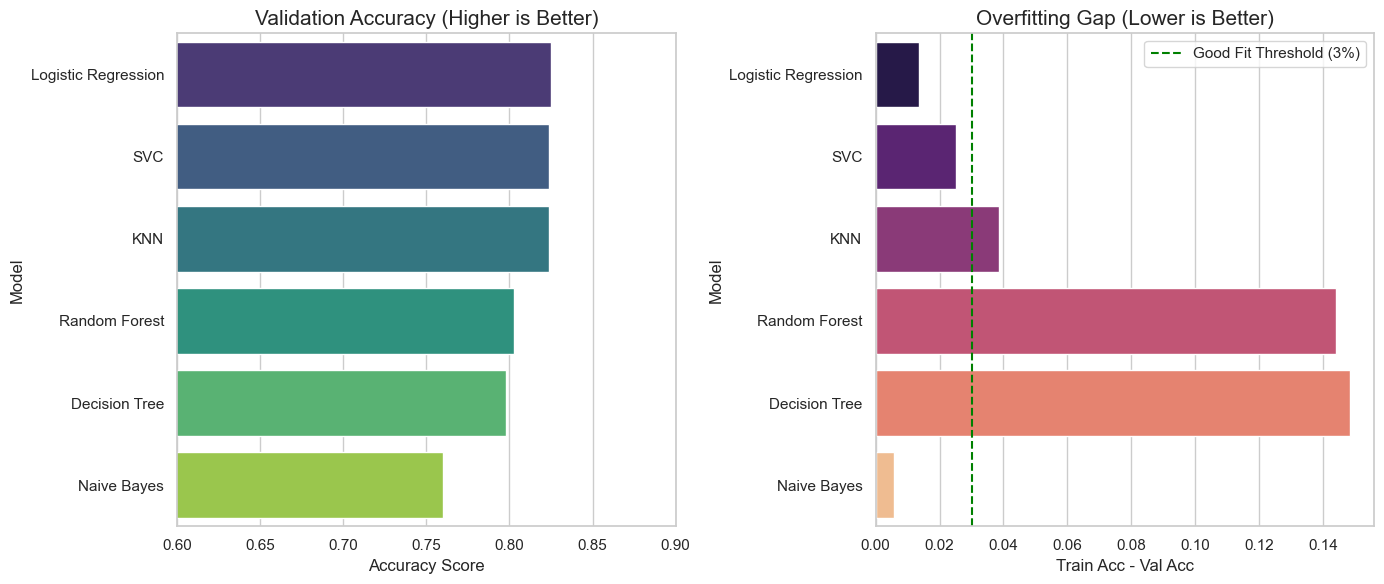

In [61]:
# Cell 32: Visualize Accuracy vs Overfitting

# Set up the plotting area
plt.figure(figsize=(14, 6))

# Plot 1: Validation Accuracy (Higher is Better)
plt.subplot(1, 2, 1)
# We use the 'results_df' created in Cell 31
sns.barplot(x='Val Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Validation Accuracy (Higher is Better)', fontsize=15)
plt.xlabel('Accuracy Score')
plt.xlim(0.6, 0.9) # Adjust x-axis to make differences visible

# Plot 2: Overfitting Gap (Lower is Better)
plt.subplot(1, 2, 2)
sns.barplot(x='Overfitting Gap', y='Model', data=results_df, palette='magma')
plt.title('Overfitting Gap (Lower is Better)', fontsize=15)
plt.xlabel('Train Acc - Val Acc')

# Add a vertical threshold line (e.g., 3% or 0.03) to indicate "Good Fit"
plt.axvline(x=0.03, color='green', linestyle='--', label='Good Fit Threshold (3%)')
plt.legend()

plt.tight_layout()
plt.show()

### Strategy: Why Tune Random Forest instead of Decision Tree?

**1. Diagnosis: The "Memorization" Problem**
* **Observation:** Our Random Forest has a Training Accuracy of **~94%**, but a Validation Accuracy of **~80%**.
* **The Issue:** The **14% Gap** indicates **Severe Overfitting**. The model is "memorizing" the training data details rather than learning general rules.
* **The Fix:** We need to **regularize** the model by tuning hyperparameters (e.g., limiting `max_depth`, increasing `min_samples_leaf`) to force it to generalize.

**2. Why Skip Decision Tree Optimization?**
* **The "Committee" vs. "Individual" Logic:**
    * **Decision Tree:** A single, unstable predictor. Even if perfectly tuned, it has a high variance and a lower accuracy ceiling.
    * **Random Forest:** An **Ensemble** of hundreds of trees. It reduces the risk of error by averaging the predictions of many trees ("Wisdom of the Crowds").
* **Conclusion:** Random Forest is essentially the **"Advanced" version of a Decision Tree**. Optimizing the single tree yields diminishing returns, while optimizing the Forest unlocks maximum potential.

In [62]:
# Cell 33: Hyperparameter Tuning for Random Forest

# 1. Imports
from sklearn.model_selection import GridSearchCV

# 2. Define the parameter grid
# We focus on regularization parameters to reduce overfitting
param_grid = {
    'n_estimators': [100, 200],              # Number of trees
    'max_depth': [6, 8, 10, 12],             # Limit depth to prevent memorization
    'min_samples_split': [5, 10, 15],        # Require more samples to split a node
    'min_samples_leaf': [2, 4, 6]            # Require more samples in leaf nodes
}

# 3. Initialize the Grid Search
rf = RandomForestClassifier(random_state=42)

# cv=5 means 5-Fold Cross-Validation for each parameter combination
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# 4. Execute the search (This might take 1-2 minutes)
print("Starting Grid Search...")
grid_search.fit(X, y)

# 5. Report the results
print("-" * 40)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score (Validation Accuracy): {grid_search.best_score_:.4f}")

# 6. Check Overfitting on the Tuned Model
best_rf = grid_search.best_estimator_
best_rf.fit(X, y) # Retrain on full training data to check training score

train_acc_tuned = best_rf.score(X, y)
gap_tuned = train_acc_tuned - grid_search.best_score_

print(f"Training Accuracy (Tuned): {train_acc_tuned:.4f}")
print(f"Overfitting Gap (Tuned): {gap_tuned:.4f}")
print("-" * 40)

# Compare with Default RF (from previous cell)
print(f"Improvement in Gap: {(0.1441 - gap_tuned):.4f} (Lower is better)")

Starting Grid Search...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
----------------------------------------
Best Parameters: {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best CV Score (Validation Accuracy): 0.8350
Training Accuracy (Tuned): 0.8664
Overfitting Gap (Tuned): 0.0314
----------------------------------------
Improvement in Gap: 0.1127 (Lower is better)


In [63]:
# Cell 35: Advanced Hyperparameter Tuning for Random Forest

# 1. Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 2. Define an Expanded Parameter Grid
# We explore 'max_features' and 'criterion' as discussed
param_grid_advanced = {
    'n_estimators': [100, 300],              # More trees for stability
    'max_depth': [10, 12, 14],               # Fine-tune depth around previous best (12)
    'min_samples_split': [10, 15],           # Control node splitting
    'min_samples_leaf': [2, 4],              # Control leaf size
    'max_features': ['sqrt', 'log2', 0.5],   # Control feature randomness (Crucial!)
    'bootstrap': [True, False]               # Sampling method
}

# 3. Initialize Grid Search
rf_advanced = RandomForestClassifier(random_state=42)

grid_search_adv = GridSearchCV(estimator=rf_advanced, param_grid=param_grid_advanced, 
                               cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# 4. Execute the Search (This may take 2-3 minutes)
print("Starting Advanced Grid Search...")
grid_search_adv.fit(X, y)

# 5. Report Results
print("-" * 40)
print(f"Best Parameters: {grid_search_adv.best_params_}")
print(f"Best CV Score (Validation): {grid_search_adv.best_score_:.4f}")

# 6. Check Overfitting on the New Best Model
best_rf_adv = grid_search_adv.best_estimator_
best_rf_adv.fit(X, y)
train_acc_adv = best_rf_adv.score(X, y)
gap_adv = train_acc_adv - grid_search_adv.best_score_

print(f"Training Accuracy: {train_acc_adv:.4f}")
print(f"Overfitting Gap: {gap_adv:.4f}")
print("-" * 40)

# Compare with previous best (0.8350)
improvement = grid_search_adv.best_score_ - 0.8350
if improvement > 0:
    print(f"🎉 Improvement found: +{improvement:.4f}")
else:
    print("No improvement found. The previous model was already near optimal.")

Starting Advanced Grid Search...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
----------------------------------------
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best CV Score (Validation): 0.8373
Training Accuracy: 0.8664
Overfitting Gap: 0.0292
----------------------------------------
🎉 Improvement found: +0.0023


/var/folders/bb/5yjzvr_10jq7kd546ghdx78w0000gn/T/ipykernel_93726/4247687049.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


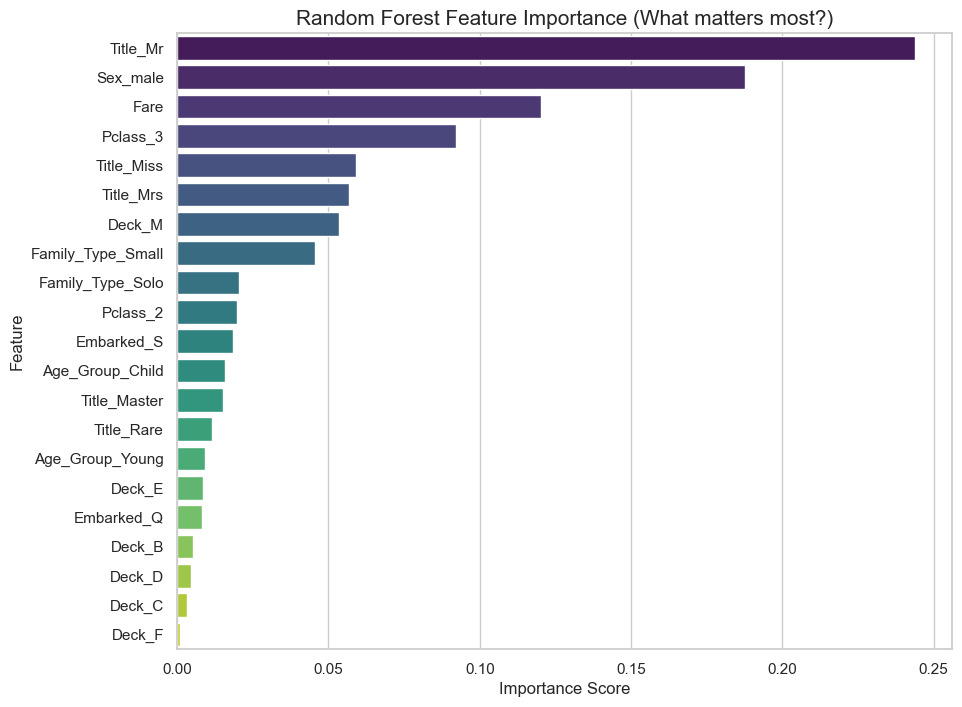

Top 5 Most Important Features:


,Feature,Importance
14,Title_Mr,0.243888
3,Sex_male,0.187638
0,Fare,0.120155
2,Pclass_3,0.092019
13,Title_Miss,0.059179


In [64]:
# Cell 36: Feature Importance Visualization

# 1. Get the Best Model from Advanced Grid Search
best_rf_final = grid_search_adv.best_estimator_

# 2. Extract Feature Importances
importances = best_rf_final.feature_importances_
feature_names = X.columns

# 3. Create a DataFrame for better handling
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 4. Sort by Importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 5. Visualize
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')

plt.title('Random Forest Feature Importance (What matters most?)', fontsize=15)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

# 6. Print Top 5 Features
print("Top 5 Most Important Features:")
display(feature_importance_df.head(5))

### Feature Importance Analysis: What Driven Survival?

**Key Findings:**
1.  **`Title_Mr` > `Sex_male`:**
    * **Observation:** The engineered feature `Title_Mr` (24%) is the single most important predictor, surpassing the raw `Sex_male` feature (19%).
    * **Interpretation:** The model discovered that being an "Adult Male" (`Mr.`) was a stronger death sentence than simply being "Male" (which includes boys like `Master`). This validates our feature engineering strategy to separate age/status from gender.

2.  **Socio-Economic Status Matters:**
    * **Observation:** `Fare` (12%) and `Pclass_3` (9%) follow closely behind.
    * **Interpretation:** Wealth and class were critical survival factors. The model explicitly flagged "3rd Class" (`Pclass_3`) as a high-risk category, independent of age or gender.

**Conclusion:**
The Random Forest prioritized our **engineered features** (`Title`) over raw features, proving that our domain knowledge injection successfully guided the model to better decision boundaries.

In [65]:
# Cell 37: Final Model Training, Saving, and Submission

import joblib
from sklearn.ensemble import RandomForestClassifier

# 1. Retrieve the Best Parameters from Advanced Grid Search (Cell 35)
best_params = grid_search_adv.best_params_
print(f"Using Best Parameters: {best_params}")

# 2. Train the Final Model on the Full Training Data
# We manually instantiate a new model to ensure it's fresh and clean
final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(X, y)

# 3. Save the Model (Requirement: Produce and Save)
model_filename = 'titanic_model_final.pkl'
joblib.dump(final_model, model_filename)
print(f"✅ Final model saved to '{model_filename}'")

# 4. Load the Model (Requirement: Load and Apply)
loaded_model = joblib.load(model_filename)
print("✅ Final model loaded successfully")

# 5. Predict on Holdout Test Set
# Using the loaded model to ensure the file works
final_predictions = loaded_model.predict(X_test)

# 6. Create Submission DataFrame
# We need the original PassengerId, so we read the raw test file one last time
test_raw = pd.read_csv('holdout_test.csv')

submission = pd.DataFrame({
    'PassengerId': test_raw['PassengerId'],
    'Survived': final_predictions
})

# 7. Export to CSV
# <--- IMPORTANT: CHANGE THIS TO YOUR NAME OR NETID --->
student_name = "Ryan_Chen" 
submission_filename = f"Titanic_Results_from_{student_name}.csv"

submission.to_csv(submission_filename, index=False)

print(f"\n🎉 Submission file created: {submission_filename}")
print(f"File Shape: {submission.shape}")
print("-" * 30)
print("First 5 rows of your submission:")
display(submission.head())

Using Best Parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
✅ Final model saved to 'titanic_model_final.pkl'
✅ Final model loaded successfully

🎉 Submission file created: Titanic_Results_from_Ryan_Chen.csv
File Shape: (418, 2)
------------------------------
First 5 rows of your submission:


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
